Let's predict Diabetes using ```'diabetes_binary_5050split_health_indicators_BRFSS2015.csv'``` file.**

In [1]:
import numpy as np 
import pandas as pd

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Set random seed and Use 'cuda' GPU

torch.manual_seed(0)

if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed_all(0)
    
else:
    device = 'cpu'

In [3]:
# Get Total Dataset
df_train = pd.read_csv('../input/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [4]:
df_train.shape

(70692, 22)

In [5]:
df_train.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [6]:
df_train['Diabetes_binary'].value_counts()

0.0    35346
1.0    35346
Name: Diabetes_binary, dtype: int64

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

As I can see with ```df_train.head()``` and ```df_train.info()```, it would be better to convert the values into **int**.

In [8]:
df_train = df_train.astype(int)

# Data Preparation

## Dataset Split

Train set + Validation set + Test set

In [9]:
# Dataset split
X = df_train.drop('Diabetes_binary', axis=1)
y = df_train['Diabetes_binary']

In [10]:
# Use 10 % of total data as Test set and the rest as (Train + Validation) set 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1)

# Use 20 % of (Train + Validation) set as Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

## Scaling

In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Convert into Tensor

In [12]:
X_train = torch.FloatTensor(X_train).to(device)
X_val = torch.FloatTensor(X_val).to(device)

y_train = torch.LongTensor(y_train.values).to(device)
y_val = torch.LongTensor(y_val.values).to(device)

# Model

In [13]:
# Hyperparameter
learning_rate = 1e-1
n_epochs = 500
drop_prob = 0.3

In [14]:
X_train.shape

torch.Size([50897, 21])

In [15]:
# Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(21, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 2)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc4(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc5(out)
        return out

In [16]:
model = Net().to(device)

# Optimizer and Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

# Train

Train with Validation

In [17]:
train_loss = list()
val_loss = list()

for epoch in range(1, n_epochs+1):
    model.train()
    H = model(X_train)
    loss = loss_fn(H, y_train)
    
    train_loss.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    acc = (torch.argmax(H, dim=1) == y_train).float().mean().item()
    
    model.eval()
    with torch.no_grad():
        H_val = model(X_val)
        loss_val = loss_fn(H_val, y_val)
        acc_val = (torch.argmax(H_val, dim=1) == y_val).float().mean().item()
        
        val_loss.append(loss_val.item())
        
    if epoch % 50 == 0:
        print('Epoch {:4d} / {}, Cost : {:.4f}, Acc : {:.2f} %, Val Cost : {:.4f}, Val Acc : {:.2f} %'.format(
            epoch, n_epochs, loss.item(), acc*100, loss_val.item(), acc_val*100))

Epoch   50 / 500, Cost : 0.5486, Acc : 72.54 %, Val Cost : 0.5315, Val Acc : 73.86 %
Epoch  100 / 500, Cost : 0.5317, Acc : 73.61 %, Val Cost : 0.5152, Val Acc : 74.29 %
Epoch  150 / 500, Cost : 0.5227, Acc : 74.15 %, Val Cost : 0.5093, Val Acc : 74.72 %
Epoch  200 / 500, Cost : 0.5195, Acc : 74.44 %, Val Cost : 0.5052, Val Acc : 75.36 %
Epoch  250 / 500, Cost : 0.5156, Acc : 74.69 %, Val Cost : 0.5026, Val Acc : 75.66 %
Epoch  300 / 500, Cost : 0.5126, Acc : 74.84 %, Val Cost : 0.5009, Val Acc : 75.62 %
Epoch  350 / 500, Cost : 0.5103, Acc : 75.18 %, Val Cost : 0.4999, Val Acc : 75.76 %
Epoch  400 / 500, Cost : 0.5092, Acc : 75.07 %, Val Cost : 0.4992, Val Acc : 75.78 %
Epoch  450 / 500, Cost : 0.5077, Acc : 75.28 %, Val Cost : 0.4990, Val Acc : 75.76 %
Epoch  500 / 500, Cost : 0.5078, Acc : 75.33 %, Val Cost : 0.4989, Val Acc : 75.72 %


Let's visualize the Train loss and Validadtion loss.

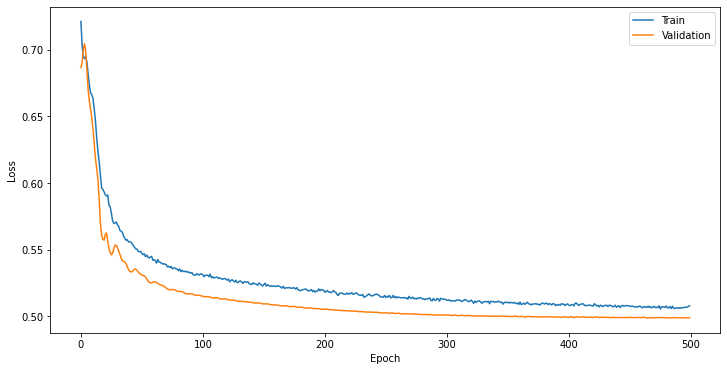

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Validation loss is lower than Train loss because of 'Dropout' layer.

# Predict Test set

Use the whole train set(Train + Validation above).

In [19]:
# Scaling
scaler = MinMaxScaler()

X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [20]:
# To Tensor
X_train_val = torch.FloatTensor(X_train_val).to(device)
X_test = torch.FloatTensor(X_test).to(device)

y_train_val = torch.LongTensor(y_train_val.values).to(device)
y_test = torch.LongTensor(y_test.values).to(device)

In [21]:
model = Net().to(device)

# Optimizer and Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

In [22]:
# Train
for epoch in range(1, n_epochs+1):
    model.train()
    H = model(X_train)
    loss = loss_fn(H, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    acc = (torch.argmax(H, dim=1) == y_train).float().mean().item()
        
    if epoch % 50 == 0:
        print('Epoch {:4d} / {}, Cost : {:.4f}, Acc : {:.2f} %'.format(
            epoch, n_epochs, loss.item(), acc*100))

Epoch   50 / 500, Cost : 0.5444, Acc : 72.88 %
Epoch  100 / 500, Cost : 0.5284, Acc : 73.75 %
Epoch  150 / 500, Cost : 0.5227, Acc : 74.19 %
Epoch  200 / 500, Cost : 0.5185, Acc : 74.49 %
Epoch  250 / 500, Cost : 0.5139, Acc : 74.87 %
Epoch  300 / 500, Cost : 0.5124, Acc : 74.86 %
Epoch  350 / 500, Cost : 0.5093, Acc : 75.08 %
Epoch  400 / 500, Cost : 0.5077, Acc : 75.17 %
Epoch  450 / 500, Cost : 0.5061, Acc : 75.30 %
Epoch  500 / 500, Cost : 0.5059, Acc : 75.29 %


In [23]:
# Predict Test set
model.eval()
with torch.no_grad():
    pred = model(X_test)

Let's check Test loss and Test accuracy.

In [24]:
test_loss = loss_fn(pred, y_test)
test_acc = (torch.argmax(pred, dim=1) == y_test).float().mean().item()

print('Test Loss : {:.4f}'.format(test_loss))
print('Test Accuacy : {:.2f} %'.format(test_acc*100))

Test Loss : 0.5135
Test Accuacy : 74.61 %


### Please **Upvote** if you like my notebook!
### Thank you!